<a href="https://colab.research.google.com/github/mohammedterry/NLP_for_ML/blob/master/Sentence_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
example_sentences = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
    
    # Cats and Dogs
    "Cats chase dogs",
    "Dogs chase cats",
]

In [0]:
def most_similar(vector, other_vectors):
  from scipy.spatial.distance import cosine

  scores = [cosine(vector, vec) for vec in other_vectors]
  ranked_candidates_idx = sorted([(score,idx) for idx,score in enumerate(scores)])
  ranked_candidates = [example_sentences[idx] for _,idx in ranked_candidates_idx[:3]]
  return ranked_candidates

In [0]:
def plot_sentences(sentences, svectors):
  %matplotlib inline
  from sklearn.decomposition import PCA
  pca = PCA(n_components=2)
  principalComponents = pca.fit_transform(svectors)

  import pandas as pd
  dataframe = pd.DataFrame(data = principalComponents, columns = ['x', 'y'])
    
  import seaborn as sns    
  graph=sns.regplot(data=dataframe, x="x", y="y", fit_reg=False, marker="+")
  [graph.text(x, y, s) for x,y,s in zip(dataframe['x'],dataframe['y'],sentences)]

In [0]:
def plot3D_sentences(sentences, svectors):
  %matplotlib inline
  from sklearn.decomposition import PCA
  pca = PCA(n_components=3)
  principalComponents = pca.fit_transform(svectors)
  
  import pandas as pd
  dataframe = pd.DataFrame(data = principalComponents, columns = ['x', 'y','z'])
  
  import matplotlib.pyplot as plt, mpl_toolkits.mplot3d
  fig = plt.figure()
  ax = fig.gca(projection='3d')
  for x, y, z, s in zip(dataframe['x'], dataframe['y'], dataframe['z'], sentences):
      ax.text(x, z, y, s, 'x')
  ax.set_xlim(min(dataframe['x']), max(dataframe['x']))
  ax.set_ylim(min(dataframe['z']), max(dataframe['z']))
  ax.set_zlim(min(dataframe['y']), max(dataframe['y']))
  plt.show()

# Char2Vec

* Idea:  Convert the sentence (string of characters) into a fixed-size vector (150 dimensions) according to the sequence of characters in its string (takes character order into account).
* Pros:  Relatively Simple
* Cons:  Sentences spellt similarly but with different meanings end up having similar vectors (e.g. "I like my phone" & "I don't like my phone")

In [0]:
!pip3 install chars2vec
import chars2vec
c2v_model = chars2vec.load_model('eng_150')

    100% |████████████████████████████████| 1.9MB 3.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/d5/60/6d/1aa6b4d074db318663a018ce60980e8856242ab28d01b45ea8
Successfully built chars2vec


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [0]:
def char2vec(sentences):
  return c2v_model.vectorize_words(sentences)

In [0]:
c2v_vectors = char2vec(example_sentences)

In [0]:
most_similar(char2vec(["i like my cell phone"]), c2v_vectors)

['My phone is not good.', 'Global warming is real', 'I like my phone']

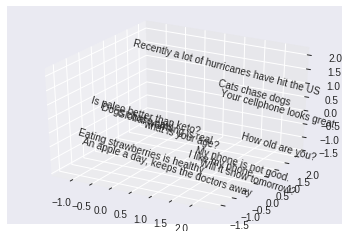

In [0]:
plot3D_sentences(example_sentences, c2v_vectors)

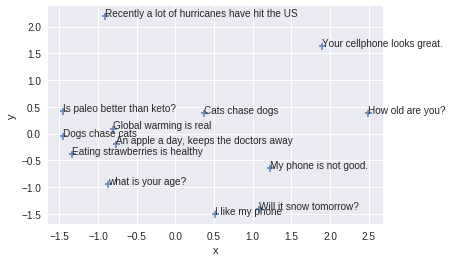

In [0]:
plot_sentences(example_sentences, c2v_vectors)

# Spacy
* Idea: Use spacy's inbuilt method for forming sentence vectors
* Pros: Simple


In [0]:
import spacy
!python3 -m spacy download en_core_web_lg
sp = spacy.load('en_core_web_lg') 

    100% |████████████████████████████████| 852.3MB 115.8MB/s 
  Running setup.py install for en-core-web-lg ... done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_lg -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_lg

    You can now load the model via spacy.load('en_core_web_lg')



In [0]:
spacy_sentences = [sp(sentence) for sentence in example_sentences]

scores = [sp("i like my cell phone").similarity(sp_sent) for sp_sent in spacy_sentences]
ranked_candidates_idx = sorted([(score,idx) for idx,score in enumerate(scores)], reverse = True)
ranked_candidates = [example_sentences[idx] for _,idx in ranked_candidates_idx[:3]]
ranked_candidates

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.']

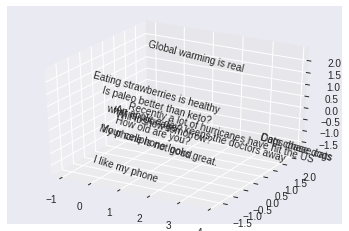

In [0]:
plot3D_sentences(example_sentences, [spacy_sentence.vector for spacy_sentence in spacy_sentences])

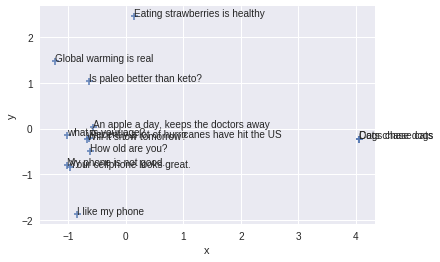

In [0]:
plot_sentences(example_sentences, [spacy_sentence.vector for spacy_sentence in spacy_sentences])

# Universal Encoder
* Idea: Sentence in -> Fixed-size Vector out (520 dimensions)
* Pros: Regardless of the number of words in the sentence, a single vector is given back
* Cons:  Compute Intensive

In [0]:
import tensorflow as tf
import tensorflow_hub as hub

tf.logging.set_verbosity(tf.logging.ERROR)

module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
embed = hub.Module(module_url)

W0309 14:40:10.564272 140264466556800 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [0]:
def universal_sentence(sentences):
  with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    vectors = session.run(embed(sentences))
    return vectors

In [0]:
uni_vectors = universal_sentence(example_sentences)

In [0]:
most_similar(universal_sentence(["i like my cell phone"]), uni_vectors)

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.']

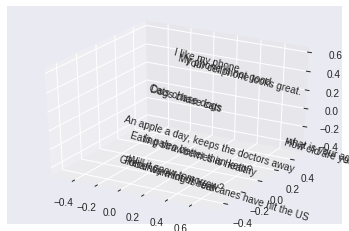

In [0]:
plot3D_sentences(example_sentences, uni_vectors)

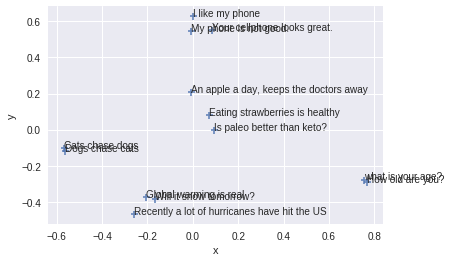

In [0]:
plot_sentences(example_sentences, uni_vectors)

# BERT as a Sentence Vector

* Method:   selects the output of the last step.  Unroll the sentence according to the time step of the word, input the vector representation of each word into a recurrent neural network(RNN), and use the output of the last time step of the RNN as the semantic representation of the sentence.  For classification tasks, the first vector (corresponding to [CLS]) is used as as the "sentence vector". Note that this only makes sense because the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
* Pros: preserves word order
* Cons: If the sentence is too long, the output of the last step does not accurately express the semantics of the sentence.


In [0]:
!pip3 install pytorch_pretrained_bert

from pytorch_pretrained_bert import BertTokenizer
tokeniser = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case = True)

from pytorch_pretrained_bert import BertModel
bert = BertModel.from_pretrained('bert-large-uncased')

import torch

    100% |████████████████████████████████| 122kB 6.3MB/s 
Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


100%|██████████| 1248501532/1248501532 [00:37<00:00, 31950299.31B/s]


In [0]:
def sentence_bert(sentence, model):
  tokenised_sentence = ["[CLS]"] + tokeniser.tokenize(sentence) +  ["[SEP]"]
  tokens_tensor = torch.tensor([tokeniser.convert_tokens_to_ids(tokenised_sentence)])
  segments_tensor = torch.tensor([[0 for _ in range(len(tokenised_sentence))]])
  encoded_layers, _ = model(tokens_tensor, segments_tensor)
  sent_vector = encoded_layers[0][-1][0]
  return sent_vector.detach().numpy()

In [0]:
bert_vectors = [sentence_bert(sentence, bert) for sentence in example_sentences]

In [0]:
most_similar(sentence_bert("i like my cell phone", bert), bert_vectors)

['I like my phone', 'what is your age?', 'How old are you?']

In [0]:
plot3D_sentences(example_sentences, bert_vectors)

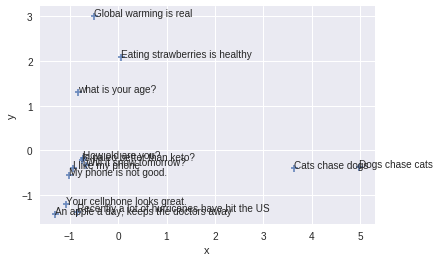

In [0]:
plot_sentences(example_sentences, bert_vectors)

# Stacked Embeddings (Char2Vec + Universal Encoder + BERT)

In [0]:
import numpy as np

def combine(vectors):
  return np.concatenate(vectors)

In [0]:
combo_vectors = [combine([a,b,c]) for a,b,c in zip(c2v_vectors, uni_vectors, bert_vectors)]

In [0]:
test_sentence = "i like my cell phone"
most_similar(combine([char2vec([test_sentence])[0],universal_sentence([test_sentence])[0], sentence_bert(test_sentence, bert)]), combo_vectors)

['I like my phone', 'My phone is not good.', 'what is your age?']

In [0]:
plot3D_sentences(example_sentences, combo_vectors)

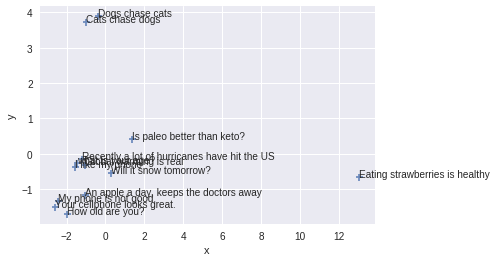

In [0]:
plot_sentences(example_sentences, combo_vectors)

# Mean Pooling of Word Vectors
Cons: The use of weighted averaging is not accurate and does not adequately express the impact of each word on sentence semantics.

In [0]:
import numpy as np

def mean_vectors(vectors, weights = None):
  return np.average(vectors, axis=0, weights = weights)

# (Tf-Idf) Weighted Average of Word Vectors

In [0]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
    
tfidf = TfidfVectorizer()
importance = tfidf.fit_transform(example_sentences) 
feature_names = tfidf.get_feature_names()
tfs = {feature_names[col] : importance[0, col]  for col in importance.nonzero()[1]}

def tfidf_weights(tokens, weights):
  ws = [0.0001 for _ in range(len(tokens))]
  for i,token in enumerate(tokens):
    if token in weights:
      w = weights[token]
      if w > 0:
        ws[i] = w
  return ws

In [55]:
from gensim.utils import tokenize

test_sentence = "i like my cell phone"
example_tokens = [token for token in tokenize(test_sentence)]
example_weights = tfidf_weights(example_tokens, tfs)
print(example_weights)
' '.join([example_token.upper()  if tfidf_weight > .5 else example_token for example_token,tfidf_weight in zip(example_tokens,example_weights)])

[0.0001, 0.6340628633768814, 0.5467925956367323, 0.0001, 0.5467925956367323]


'i LIKE MY cell PHONE'

## BERT

In [0]:
def convert_to_bert(sentence, model):
  tokenised_sentence = tokeniser.tokenize(sentence)
  tokens_tensor = torch.tensor([tokeniser.convert_tokens_to_ids(tokenised_sentence)])
  segments_tensor = torch.tensor([[0 for _ in range(len(tokenised_sentence))]])
  encoded_layers, _ = model(tokens_tensor, segments_tensor)
  bert_vectors = encoded_layers[0][-1]
  return bert_vectors.detach().numpy()

In [0]:
mean_bert_vectors = [mean_vectors(convert_to_bert(sentence, bert)) for sentence in example_sentences]
w_mean_bert_vectors = [mean_vectors(convert_to_bert(sentence, bert), tfidf_weights(tokeniser.tokenize(sentence), tfs)) for sentence in example_sentences]

In [0]:
most_similar(mean_vectors(convert_to_bert(test_sentence, bert)), mean_bert_vectors)

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.']

In [0]:
plot3D_sentences(example_sentences, mean_bert_vectors)

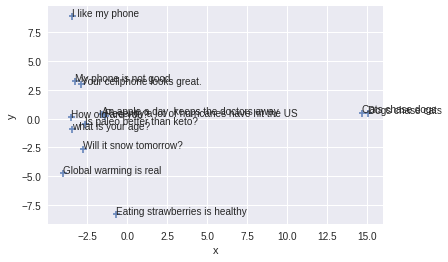

In [0]:
plot_sentences(example_sentences, mean_bert_vectors)

In [0]:
most_similar(mean_vectors(convert_to_bert(test_sentence, bert), tfidf_weights(tokeniser.tokenize(test_sentence), tfs)), w_mean_bert_vectors)

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.']

In [0]:
plot3D_sentences(example_sentences, w_mean_bert_vectors)

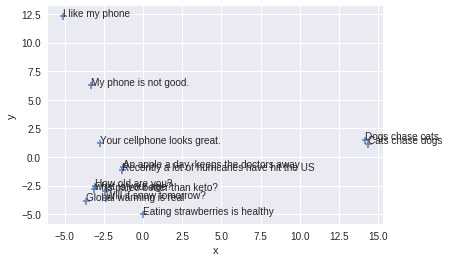

In [0]:
plot_sentences(example_sentences, w_mean_bert_vectors)

## ELMO

In [0]:
!pip3 install allennlp
from allennlp.commands.elmo import ElmoEmbedder
elmo = ElmoEmbedder()

    100% |████████████████████████████████| 5.6MB 5.6MB/s 
    100% |████████████████████████████████| 512kB 22.5MB/s 
    100% |████████████████████████████████| 51kB 19.9MB/s 
    100% |████████████████████████████████| 552kB 22.9MB/s 
    100% |████████████████████████████████| 245kB 27.2MB/s 
    100% |████████████████████████████████| 12.6MB 2.9MB/s 
    100% |████████████████████████████████| 133kB 32.9MB/s 
    100% |████████████████████████████████| 1.5MB 14.2MB/s 
    100% |████████████████████████████████| 4.5MB 6.7MB/s 
    100% |████████████████████████████████| 51kB 18.9MB/s 
    100% |████████████████████████████████| 143kB 30.8MB/s 
    100% |████████████████████████████████| 2.3MB 11.4MB/s 
    100% |████████████████████████████████| 51kB 19.1MB/s 
    100% |████████████████████████████████| 61kB 17.9MB/s 
    100% |████████████████████████████████| 51kB 18.4MB/s 
    100% |████████████████████████████████| 7.5MB 5.1MB/s 
    100% |████████████████████████████████| 92kB

100%|██████████| 374434792/374434792 [00:13<00:00, 27453086.02B/s]


In [0]:
def convert_to_elmo(sentence, model):
  return elmo.embed_sentence(sentence.split())[-1]

In [0]:
mean_elmo_vectors = [mean_vectors(convert_to_elmo(sentence, elmo)) for sentence in example_sentences]
w_mean_elmo_vectors = [mean_vectors(convert_to_elmo(sentence, elmo), tfidf_weights([token for token in tokenize(sentence)], tfs)) for sentence in example_sentences]

In [0]:
most_similar(mean_vectors(convert_to_elmo(test_sentence, elmo)), mean_elmo_vectors)

['I like my phone', 'Your cellphone looks great.', 'My phone is not good.']

In [0]:
plot3D_sentences(example_sentences, mean_elmo_vectors)

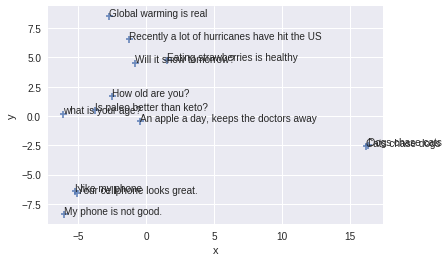

In [0]:
plot_sentences(example_sentences, mean_elmo_vectors)

In [0]:
most_similar(mean_vectors(convert_to_elmo(test_sentence, elmo), example_weights), w_mean_elmo_vectors)

['I like my phone', 'Your cellphone looks great.', 'what is your age?']

In [0]:
plot3D_sentences(example_sentences, w_mean_elmo_vectors)

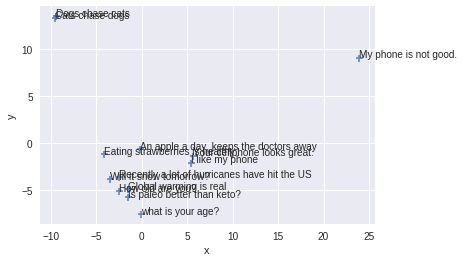

In [0]:
plot_sentences(example_sentences, w_mean_elmo_vectors)

## FastText & GloVe

In [0]:
!pip3 install mxnet
!pip3 install gluonnlp

import gluonnlp
fasttext = gluonnlp.embedding.create('fasttext', source='wiki.simple')
glove = gluonnlp.embedding.create('glove', source='glove.6B.300d') 

    100% |████████████████████████████████| 28.4MB 651kB/s 
    100% |████████████████████████████████| 61kB 6.2MB/s 
spacy 2.0.18 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
google-colab 1.0.0 has requirement requests~=2.18.0, but you'll have requests 2.21.0 which is incompatible.
fastai 1.0.46 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
  Found existing installation: requests 2.18.4
    Uninstalling requests-2.18.4:
      Successfully uninstalled requests-2.18.4
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


    100% |████████████████████████████████| 194kB 6.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/19/c4/f4/70dc14c8b01db12cd4f88c6f71128bb88de545a7690e192ce0
Successfully built gluonnlp
Embedding file wiki.simple.npz is not found. Downloading from Gluon Repository. This may take some time.
Embedding file glove.6B.300d.npz is not found. Downloading from Gluon Repository. This may take some time.


In [0]:
def convert_to_ft_glove(sentence,model):
  return [model[word].asnumpy() for word in sentence.split()]

In [0]:
mean_fasttext_vectors = [mean_vectors(convert_to_ft_glove(sentence, fasttext)) for sentence in example_sentences]
w_mean_fasttext_vectors = [mean_vectors(convert_to_ft_glove(sentence, fasttext), tfidf_weights([token for token in tokenize(sentence)], tfs)) for sentence in example_sentences]

mean_glove_vectors = [mean_vectors(convert_to_ft_glove(sentence, glove)) for sentence in example_sentences]
w_mean_glove_vectors = [mean_vectors(convert_to_ft_glove(sentence, glove), tfidf_weights([token for token in tokenize(sentence)], tfs)) for sentence in example_sentences]

In [0]:
most_similar(mean_vectors(convert_to_ft_glove(test_sentence, fasttext)), mean_fasttext_vectors)

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.']

In [0]:
plot3D_sentences(example_sentences, mean_fasttext_vectors)

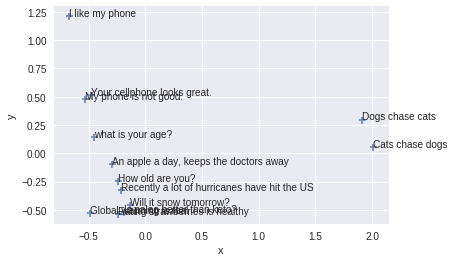

In [0]:
plot_sentences(example_sentences, mean_fasttext_vectors)

In [0]:
most_similar(mean_vectors(convert_to_ft_glove(test_sentence, fasttext),example_weights), w_mean_fasttext_vectors)

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.']

In [0]:
plot3D_sentences(example_sentences, w_mean_fasttext_vectors)

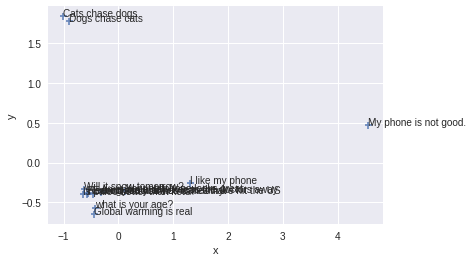

In [0]:
plot_sentences(example_sentences, w_mean_fasttext_vectors)

In [0]:
most_similar(mean_vectors(convert_to_ft_glove(test_sentence, glove)), mean_glove_vectors)

['I like my phone', 'My phone is not good.', 'what is your age?']

In [0]:
plot3D_sentences(example_sentences, mean_glove_vectors)

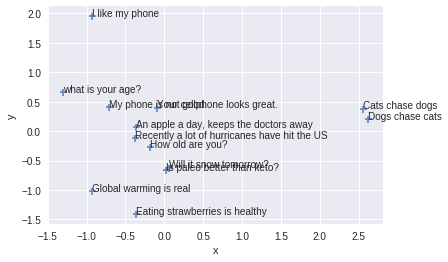

In [0]:
plot_sentences(example_sentences, mean_glove_vectors)

In [0]:
most_similar(mean_vectors(convert_to_ft_glove(test_sentence, glove), example_weights), w_mean_glove_vectors)

['I like my phone', 'what is your age?', 'My phone is not good.']

In [0]:
plot3D_sentences(example_sentences, w_mean_glove_vectors)

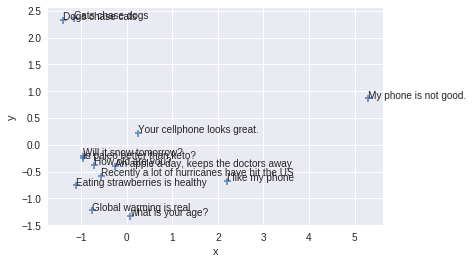

In [0]:
plot_sentences(example_sentences, w_mean_glove_vectors)

## NumberBatch (using Gensim)

In [0]:
!wget https://conceptnet.s3.amazonaws.com/downloads/2017/numberbatch/numberbatch-17.06.txt.gz
!gunzip numberbatch-17.06.txt.gz

--2019-03-08 20:16:28--  https://conceptnet.s3.amazonaws.com/downloads/2017/numberbatch/numberbatch-17.06.txt.gz
Resolving conceptnet.s3.amazonaws.com (conceptnet.s3.amazonaws.com)... 52.216.101.251
Connecting to conceptnet.s3.amazonaws.com (conceptnet.s3.amazonaws.com)|52.216.101.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1193268949 (1.1G) [text/plain]
Saving to: ‘numberbatch-17.06.txt.gz’

numberbatch-17.06.t 100%[===================>]   1.11G  56.4MB/s    in 21s     

2019-03-08 20:16:49 (53.9 MB/s) - ‘numberbatch-17.06.txt.gz’ saved [1193268949/1193268949]



In [0]:
from gensim.models.keyedvectors import KeyedVectors
numberbatch = KeyedVectors.load_word2vec_format("numberbatch-17.06.txt", binary=False)

In [0]:
from gensim.utils import tokenize

def convert_to_numberbatch(sentence, language = "en"):
  tokens = [token.lower().replace(' ','_') for token in tokenize(sentence)]
  return [numberbatch[f"/c/{language}/{token}"] for token in tokens]

In [0]:
mean_numberbatch_vectors = [mean_vectors(convert_to_numberbatch(sentence)) for sentence in example_sentences]
w_mean_numberbatch_vectors = [mean_vectors(convert_to_numberbatch(sentence), tfidf_weights([token for token in tokenize(sentence)], tfs)) for sentence in example_sentences]

In [0]:
most_similar(mean_vectors(convert_to_numberbatch(test_sentence)), mean_numberbatch_vectors)

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.']

In [0]:
plot3D_sentences(example_sentences, mean_numberbatch_vectors)

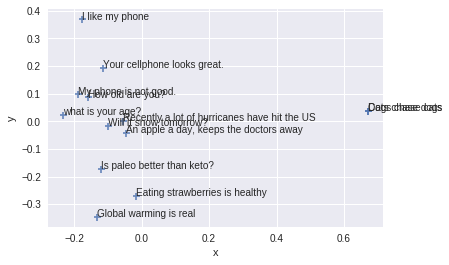

In [0]:
plot_sentences(example_sentences, mean_numberbatch_vectors)

In [0]:
most_similar(mean_vectors(convert_to_numberbatch(test_sentence), example_weights), w_mean_numberbatch_vectors)

['I like my phone', 'Your cellphone looks great.', 'My phone is not good.']

In [0]:
plot3D_sentences(example_sentences, w_mean_numberbatch_vectors)

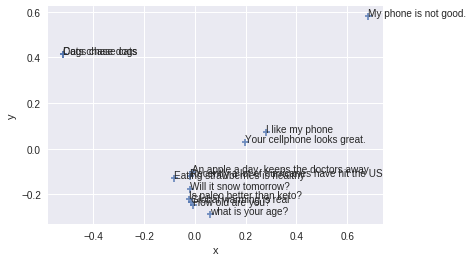

In [0]:
plot_sentences(example_sentences, w_mean_numberbatch_vectors)

## FLAIR

In [28]:
!pip3 install flair

2019-03-11 11:09:55,027 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings-v0.4.1/big-news-forward--h2048-l1-d0.05-lr30-0.25-20/news-forward-0.4.1.pt not found in cache, downloading to /tmp/tmpjpwcponb


100%|██████████| 73034624/73034624 [00:03<00:00, 19214732.69B/s]

2019-03-11 11:09:59,352 copying /tmp/tmpjpwcponb to cache at /root/.flair/embeddings/news-forward-0.4.1.pt


2019-03-11 11:09:59,456 removing temp file /tmp/tmpjpwcponb
2019-03-11 11:10:00,252 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings-v0.4.1/big-news-backward--h2048-l1-d0.05-lr30-0.25-20/news-backward-0.4.1.pt not found in cache, downloading to /tmp/tmp7a36wmah


100%|██████████| 73034575/73034575 [00:03<00:00, 18277353.37B/s]

2019-03-11 11:10:04,800 copying /tmp/tmp7a36wmah to cache at /root/.flair/embeddings/news-backward-0.4.1.pt


2019-03-11 11:10:04,906 removing temp file /tmp/tmp7a36wmah


In [0]:
from flair.embeddings import FlairEmbeddings, StackedEmbeddings, Sentence
stacked_embeddings = StackedEmbeddings([FlairEmbeddings('news-forward'), FlairEmbeddings('news-backward')])

def convert_to_flair(sentence):
  s = Sentence(sentence)
  stacked_embeddings.embed(s)
  return [token.embedding.detach().numpy() for token in s]

In [0]:
mean_flair_vectors = [mean_vectors(convert_to_flair(sentence)) for sentence in example_sentences]
w_mean_flair_vectors = [mean_vectors(convert_to_flair(sentence), tfidf_weights([token for token in tokenize(sentence)], tfs)) for sentence in example_sentences]

In [59]:
most_similar(mean_vectors(convert_to_flair(test_sentence)), mean_flair_vectors)

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.']

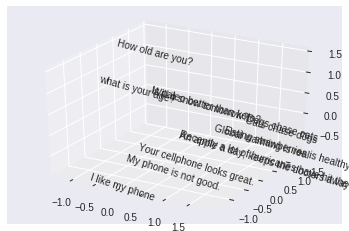

In [60]:
plot3D_sentences(example_sentences, mean_flair_vectors)

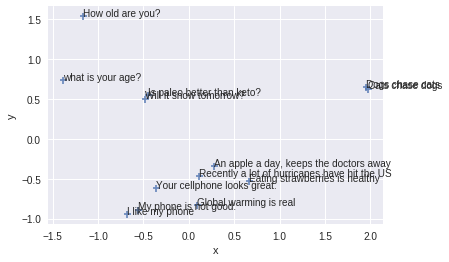

In [61]:
plot_sentences(example_sentences, mean_flair_vectors)

In [78]:
most_similar(mean_vectors(convert_to_flair(test_sentence), example_weights), w_mean_flair_vectors)

['I like my phone', 'Your cellphone looks great.', 'My phone is not good.']

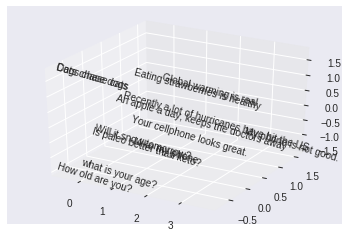

In [64]:
plot3D_sentences(example_sentences, w_mean_flair_vectors)

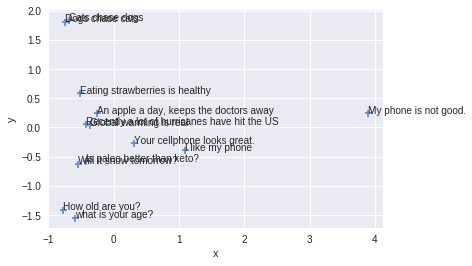

In [65]:
plot_sentences(example_sentences, w_mean_flair_vectors)

## Ensemble Embeddings (Flair + Glove + BERT + ELMo)

In [67]:
!pip3 install flair
!pip3 install allennlp

    100% |████████████████████████████████| 5.6MB 2.1MB/s 
    100% |████████████████████████████████| 245kB 28.6MB/s 
    100% |████████████████████████████████| 552kB 25.2MB/s 
    100% |████████████████████████████████| 4.5MB 8.5MB/s 
    100% |████████████████████████████████| 51kB 22.6MB/s 
    100% |████████████████████████████████| 1.5MB 16.3MB/s 
    100% |████████████████████████████████| 512kB 23.7MB/s 
    100% |████████████████████████████████| 12.6MB 1.1MB/s 
    100% |████████████████████████████████| 51kB 22.5MB/s 
    100% |████████████████████████████████| 133kB 33.4MB/s 
    100% |████████████████████████████████| 51kB 21.8MB/s 
    100% |████████████████████████████████| 61kB 24.2MB/s 
    100% |████████████████████████████████| 2.3MB 14.0MB/s 
    100% |████████████████████████████████| 143kB 36.2MB/s 
    100% |████████████████████████████████| 51kB 24.0MB/s 
    100% |████████████████████████████████| 7.5MB 5.6MB/s 
    100% |████████████████████████████████| 92kB

In [0]:
from flair.embeddings import FlairEmbeddings, BertEmbeddings, StackedEmbeddings, ELMoEmbeddings, Sentence

flair_forward_embedding = FlairEmbeddings('multi-forward')
flair_backward_embedding = FlairEmbeddings('multi-backward')
bert_embedding = BertEmbeddings('bert-base-multilingual-cased')
elmo_embedding = ELMoEmbeddings()
glove_embedding = WordEmbeddings('glove')

ensemble_embeddings = StackedEmbeddings(embeddings=[flair_forward_embedding, flair_backward_embedding, bert_embedding, elmo_embedding, glove_embedding])

def convert_to_ensemble(sentence):
  s = Sentence(sentence)
  ensemble_embeddings.embed(s)
  return [token.embedding.detach().numpy() for token in s]

In [0]:
mean_ensemble_vectors = [mean_vectors(convert_to_ensemble(sentence)) for sentence in example_sentences]
w_mean_ensemble_vectors = [mean_vectors(convert_to_ensemble(sentence), tfidf_weights([token for token in tokenize(sentence)], tfs)) for sentence in example_sentences]

In [79]:
most_similar(mean_vectors(convert_to_ensemble(test_sentence)), mean_ensemble_vectors)

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.']

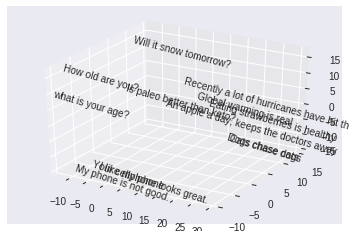

In [80]:
plot3D_sentences(example_sentences, mean_ensemble_vectors)

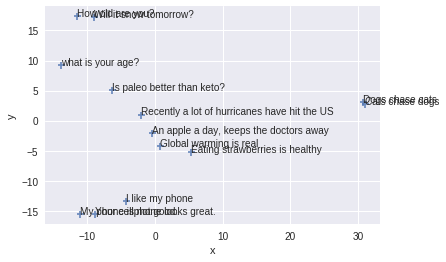

In [81]:
plot_sentences(example_sentences, mean_ensemble_vectors)

In [82]:
most_similar(mean_vectors(convert_to_ensemble(test_sentence), example_weights), w_mean_ensemble_vectors)

['I like my phone',
 'Your cellphone looks great.',
 'An apple a day, keeps the doctors away']

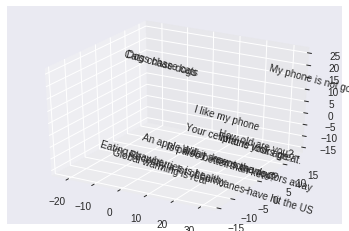

In [83]:
plot3D_sentences(example_sentences, w_mean_ensemble_vectors)

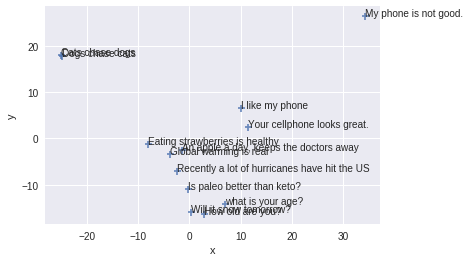

In [84]:
plot_sentences(example_sentences, w_mean_ensemble_vectors)

# RNN pooling 
* Method: use the last embedding for an RNN as the combine embedding for all the words before it
* Pros: convenient
* Cons: unreliable results

In [90]:
!pip3 install flair
from flair.embeddings import WordEmbeddings, DocumentRNNEmbeddings, Sentence

glove_embedding = WordEmbeddings('glove')
document_embeddings = DocumentRNNEmbeddings([glove_embedding])

def rnn_pool(sentence):
  s = Sentence(sentence)
  document_embeddings.embed(s)
  return s.get_embedding().detach().numpy()

In [0]:
rnn_vectors = [rnn_pool(sentence) for sentence in example_sentences]

In [92]:
most_similar(rnn_pool("i like my cell phone"), rnn_vectors)

['My phone is not good.', 'Your cellphone looks great.', 'what is your age?']

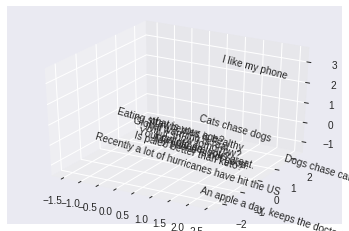

In [93]:
plot3D_sentences(example_sentences, rnn_vectors)

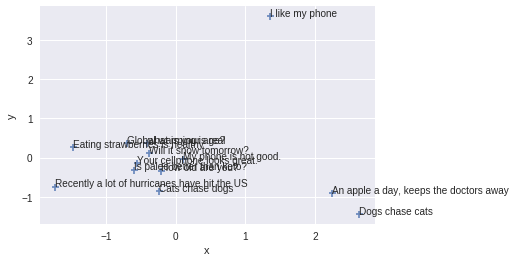

In [94]:
plot_sentences(example_sentences,rnn_vectors)

# CNN pooling
* Method: Convolution(CNN) and maximum pooling(MaxPooling) on the matrix of all the word vectors of the sentence, using the final result to represent the semantics of the sentence.
* Cons: Many useful word meanings may be lost

# Random Projection Word Vectors

# Stacked Autoencoders

# A Structured Self-attentive Sentence Embedding

In [0]:
#!pip3 install mxnet
#!pip3 install gluonnlp
import os, json, zipfile, time, itertools
import numpy as np
import mxnet as mx
import multiprocessing as mp
import gluonnlp as nlp

from mxnet import  autograd, gluon, nd, init
from mxnet.gluon import nn, rnn

from sklearn.metrics import accuracy_score, f1_score
np.random.seed(2018)
mx.random.seed(2018)

def try_gpu():
    try:
        ctx = mx.gpu()
        _ = nd.array([0], ctx=ctx)
    except:
        ctx = mx.cpu()
    return ctx

In [0]:
data_url = 'http://apache-mxnet.s3-accelerate.dualstack.amazonaws.com/gluon/dataset/yelp_review_subset-167bb781.zip'
zip_path = mx.gluon.utils.download(data_url)

# unzip the zip file.
zip_file = zipfile.ZipFile(zip_path)
json_path = zip_file.extract(zip_file.namelist()[0])

## load json data.
with open(json_path, 'r', encoding='utf-8') as fr:
    data = json.load(fr)

# create a list of review a label paris.
dataset = [[text, int(label)] for text, label in zip(data['texts'], data['labels'])]

# randomly divide one percent from the training set as a verification set.
train_dataset, valid_dataset = nlp.data.train_valid_split(dataset, 0.01)
len(train_dataset), len(valid_dataset)

(198000, 2000)

In [0]:
# tokenizer takes as input a string and outputs a list of tokens.
tokenizer = nlp.data.SpacyTokenizer('en')

# length_clip takes as input a list and outputs a list with maximum length 100.
length_clip = nlp.data.ClipSequence(100)

def preprocess(x):

    # convert the number of stars 1, 2, 3, 4, 5 to zero-based index, 0, 1, 2, 3, 4
    data, label = x[0], x[1]-1

    # clip the length of review words
    data = length_clip(tokenizer(data))
    return data, label

def get_length(x):
    return float(len(x[0]))

def preprocess_dataset(dataset):
    start = time.time()

    with mp.Pool() as pool:
        # Each sample is processed in an asynchronous manner.
        dataset = gluon.data.SimpleDataset(pool.map(preprocess, dataset))
        lengths = gluon.data.SimpleDataset(pool.map(get_length, dataset))
    end = time.time()

    print('Done! Tokenizing Time={:.2f}s, #Sentences={}'.format(end - start, len(dataset)))
    return dataset, lengths

# Preprocess the dataset
train_dataset, train_data_lengths = preprocess_dataset(train_dataset)
valid_dataset, valid_data_lengths = preprocess_dataset(valid_dataset)

Done! Tokenizing Time=122.10s, #Sentences=198000
Done! Tokenizing Time=2.01s, #Sentences=2000


In [0]:
# create vocab
train_seqs = [sample[0] for sample in train_dataset]
counter = nlp.data.count_tokens(list(itertools.chain.from_iterable(train_seqs)))

vocab = nlp.Vocab(counter, max_size=10000)

# load pre-trained embedding,Glove
embedding_weights = nlp.embedding.GloVe(source='glove.6B.300d')
vocab.set_embedding(embedding_weights)
print(vocab)

def token_to_idx(x):
    return vocab[x[0]], x[1]

# A token index or a list of token indices is returned according to the vocabulary.
with mp.Pool() as pool:
    train_dataset = pool.map(token_to_idx, train_dataset)
    valid_dataset = pool.map(token_to_idx, valid_dataset)

Embedding file glove.6B.300d.npz is not found. Downloading from Gluon Repository. This may take some time.
Vocab(size=10004, unk="<unk>", reserved="['<pad>', '<bos>', '<eos>']")


In [0]:
batch_size = 64
bucket_num = 10
bucket_ratio = 0.5


def get_dataloader():
    # Construct the DataLoader Pad data, stack label and lengths
    batchify_fn = nlp.data.batchify.Tuple(
        nlp.data.batchify.Pad(axis=0),
        nlp.data.batchify.Stack())

    # n this example, we use a FixedBucketSampler,
    # which assigns each data sample to a fixed bucket based on its length.
    batch_sampler = nlp.data.sampler.FixedBucketSampler(
        train_data_lengths,
        batch_size=batch_size,
        num_buckets=bucket_num,
        ratio=bucket_ratio,
        shuffle=True)
    print(batch_sampler.stats())

    # train_dataloader
    train_dataloader = gluon.data.DataLoader(
        dataset=train_dataset,
        batch_sampler=batch_sampler,
        batchify_fn=batchify_fn)
    # valid_dataloader
    valid_dataloader = gluon.data.DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        batchify_fn=batchify_fn)
    return train_dataloader, valid_dataloader

train_dataloader, valid_dataloader = get_dataloader()

FixedBucketSampler:
  sample_num=198000, batch_num=2922
  key=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
  cnt=[269, 4493, 13820, 14966, 15003, 14056, 12906, 11671, 10268, 100548]
  batch_size=[320, 160, 106, 80, 64, 64, 64, 64, 64, 64]


In [0]:
# custom attention layer
class SelfAttention(nn.HybridBlock):
    def __init__(self, att_unit, att_hops, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        with self.name_scope():
            self.ut_dense = nn.Dense(att_unit, activation='tanh', flatten=False)
            self.et_dense = nn.Dense(att_hops, activation=None, flatten=False)

    def hybrid_forward(self, F, x):
        # x shape: [batch_size, seq_len, embedding_width]
        # ut shape: [batch_size, seq_len, att_unit]
        ut = self.ut_dense(x)
        # et shape: [batch_size, seq_len, att_hops]
        et = self.et_dense(ut)

        # att shape: [batch_size,  att_hops, seq_len]
        att = F.softmax(F.transpose(et, axes=(0, 2, 1)), axis=-1)
        # output shape [batch_size, att_hops, embedding_width]
        output = F.batch_dot(att, x)

        return output, att

class WeightedSoftmaxCE(nn.HybridBlock):
    def __init__(self, sparse_label=True, from_logits=False,  **kwargs):
        super(WeightedSoftmaxCE, self).__init__(**kwargs)
        with self.name_scope():
            self.sparse_label = sparse_label
            self.from_logits = from_logits

    def hybrid_forward(self, F, pred, label, class_weight, depth=None):
        if self.sparse_label:
            label = F.reshape(label, shape=(-1, ))
            label = F.one_hot(label, depth)
        if not self.from_logits:
            pred = F.log_softmax(pred, -1)

        weight_label = F.broadcast_mul(label, class_weight)
        loss = -F.sum(pred * weight_label, axis=-1)

        # return F.mean(loss, axis=0, exclude=True)
        return loss
  
class SelfAttentiveBiLSTM(nn.HybridBlock):
    def __init__(self, vocab_len, embsize, nhidden, nlayers, natt_unit, natt_hops, nfc, nclass,
                 drop_prob, pool_way, prune_p=None, prune_q=None, **kwargs):
        super(SelfAttentiveBiLSTM, self).__init__(**kwargs)
        with self.name_scope():
            self.embedding_layer = nn.Embedding(vocab_len, embsize)
            self.bilstm = rnn.LSTM(nhidden, num_layers=nlayers, dropout=drop_prob, bidirectional=True)
            self.att_encoder = SelfAttention(natt_unit, natt_hops)
            self.dense = nn.Dense(nfc, activation='tanh')
            self.output_layer = nn.Dense(nclass)

            self.dense_p, self.dense_q = None, None
            if all([prune_p, prune_q]):
                self.dense_p = nn.Dense(prune_p, activation='tanh', flatten=False)
                self.dense_q = nn.Dense(prune_q, activation='tanh', flatten=False)

            self.drop_prob = drop_prob
            self.pool_way = pool_way

    def hybrid_forward(self, F, inp):
        # input_embed: [batch, len, emsize]
        inp_embed = self.embedding_layer(inp)
        h_output = self.bilstm(F.transpose(inp_embed, axes=(1, 0, 2)))
        # att_output: [batch, att_hops, emsize]
        att_output, att = self.att_encoder(F.transpose(h_output, axes=(1, 0, 2)))

        dense_input = None
        if self.pool_way == 'flatten':
            dense_input = F.Dropout(F.flatten(att_output), self.drop_prob)
        elif self.pool_way == 'mean':
            dense_input = F.Dropout(F.mean(att_output, axis=1), self.drop_prob)
        elif self.pool_way == 'prune' and all([self.dense_p, self.dense_q]):
            # p_section: [batch, att_hops, prune_p]
            p_section = self.dense_p(att_output)
            # q_section: [batch, emsize, prune_q]
            q_section = self.dense_q(F.transpose(att_output, axes=(0, 2, 1)))
            dense_input = F.Dropout(F.concat(F.flatten(p_section), F.flatten(q_section), dim=-1), self.drop_prob)

        dense_out = self.dense(dense_input)
        output = self.output_layer(F.Dropout(dense_out, self.drop_prob))

        return output, att

In [0]:
vocab_len = len(vocab)
emsize = 300   # word embedding size
nhidden = 300    # lstm hidden_dim
nlayers = 2     # lstm layers
natt_unit = 300     # the hidden_units of attenion layer
natt_hops = 2    # the channels of attention
nfc = 512
nclass = 5

drop_prob = 0.5
pool_way = 'flatten'    # # The way to handle M
prune_p = None
prune_q = None

ctx = try_gpu()

model = SelfAttentiveBiLSTM(vocab_len, emsize, nhidden, nlayers,
                            natt_unit, natt_hops, nfc, nclass,
                            drop_prob, pool_way, prune_p, prune_q)

model.initialize(init=init.Xavier(), ctx=ctx)
model.hybridize()

# Attach a pre-trained glove word vector to the embedding layer
model.embedding_layer.weight.set_data(vocab.embedding.idx_to_vec)
# fixed the layer
model.embedding_layer.collect_params().setattr('grad_req', 'null')

In [0]:
def calculate_loss(x, y, model, loss, class_weight, penal_coeff):
    pred, att = model(x)
    if loss_name == 'sce':
        l = loss(pred, y)
    elif loss_name == 'wsce':
        l = loss(pred, y, class_weight, class_weight.shape[0])

    # penalty
    diversity_penalty = nd.batch_dot(att, nd.transpose(att, axes=(0, 2, 1))
                        ) - nd.eye(att.shape[1], ctx=att.context)
    l = l + penal_coeff * diversity_penalty.norm(axis=(1, 2))

    return pred, l

def one_epoch(data_iter, model, loss, trainer, ctx, is_train, epoch,
              penal_coeff=0.0, clip=None, class_weight=None, loss_name='wsce'):

    loss_val = 0.
    total_pred = []
    total_true = []
    n_batch = 0

    for batch_x, batch_y in data_iter:
        batch_x = batch_x.as_in_context(ctx)
        batch_y = batch_y.as_in_context(ctx)

        if is_train:
            with autograd.record():
                batch_pred, l = calculate_loss(batch_x, batch_y, model, loss, class_weight, penal_coeff)

            # backward calculate
            l.backward()

            # clip gradient
            clip_params = [p.data() for p in model.collect_params().values()]
            if clip is not None:
                norm = nd.array([0.0], ctx)
                for param in clip_params:
                    if param.grad is not None:
                        norm += (param.grad ** 2).sum()
                norm = norm.sqrt().asscalar()
                if norm > clip:
                    for param in clip_params:
                        if param.grad is not None:
                            param.grad[:] *= clip / norm

            # update parmas
            trainer.step(batch_x.shape[0])

        else:
            batch_pred, l = calculate_loss(batch_x, batch_y, model, loss, class_weight, penal_coeff)

        # keep result for metric
        batch_pred = nd.argmax(nd.softmax(batch_pred, axis=1), axis=1).asnumpy()
        batch_true = np.reshape(batch_y.asnumpy(), (-1, ))
        total_pred.extend(batch_pred.tolist())
        total_true.extend(batch_true.tolist())

        batch_loss = l.mean().asscalar()

        n_batch += 1
        loss_val += batch_loss

        # check the result of traing phase
        if is_train and n_batch % 400 == 0:
            print('epoch %d, batch %d, batch_train_loss %.4f, batch_train_acc %.3f' %
                  (epoch, n_batch, batch_loss, accuracy_score(batch_true, batch_pred)))

    # metric
    F1 = f1_score(np.array(total_true), np.array(total_pred), average='weighted')
    acc = accuracy_score(np.array(total_true), np.array(total_pred))
    loss_val /= n_batch

    if is_train:
        print('epoch %d, learning_rate %.5f \n\t train_loss %.4f, acc_train %.3f, F1_train %.3f, ' %
              (epoch, trainer.learning_rate, loss_val, acc, F1))
        # declay lr
        if epoch % 2 == 0:
            trainer.set_learning_rate(trainer.learning_rate * 0.9)
    else:
        print('\t valid_loss %.4f, acc_valid %.3f, F1_valid %.3f, ' % (loss_val, acc, F1))

def train_valid(data_iter_train, data_iter_valid, model, loss, trainer, ctx, nepochs,
                penal_coeff=0.0, clip=None, class_weight=None, loss_name='wsce'):

    for epoch in range(1, nepochs+1):
        start = time.time()
        # train
        is_train = True
        one_epoch(data_iter_train, model, loss, trainer, ctx, is_train,
                  epoch, penal_coeff, clip, class_weight, loss_name)

        # valid
        is_train = False
        one_epoch(data_iter_valid, model, loss, trainer, ctx, is_train,
                  epoch, penal_coeff, clip, class_weight, loss_name)
        end = time.time()
        print('time %.2f sec' % (end-start))
        print("*"*100)


In [0]:
class_weight = None
loss_name = 'wsce'
optim = 'adam'
lr = 0.001
penal_coeff = 0.1
clip = 0.5
nepochs = 4

trainer = gluon.Trainer(model.collect_params(), optim, {'learning_rate': lr})

if loss_name == 'sce':
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
elif loss_name == 'wsce':
    loss = WeightedSoftmaxCE()
    # the value of class_weight is obtained by counting data in advance. It can be seen as a hyperparameter.
    class_weight = nd.array([3.0, 5.3, 4.0, 2.0, 1.0], ctx=ctx)

In [0]:
# train and valid
train_valid(train_dataloader, valid_dataloader, model, loss, trainer, ctx, nepochs,
            penal_coeff=penal_coeff, clip=clip, class_weight=class_weight, loss_name=loss_name)

KeyboardInterrupt: ignored

In [0]:
input_ar = nd.array(vocab["i like my cell phone".split()], ctx=ctx).reshape((1, -1))
pred, att = model(input_ar)

label = np.argmax(nd.softmax(pred, axis=1).asnumpy(), axis=1) + 1
print(label)
print(att)

[1]

[[[0.19128479 0.20271531 0.20424148 0.20328462 0.19847372]
  [0.19777183 0.20537338 0.20406838 0.20066795 0.19211844]]]
<NDArray 1x2x5 @cpu(0)>


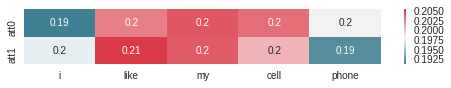

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.squeeze(att.asnumpy(), 0).shape
plt.figure(figsize=(8,1))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(np.squeeze(att.asnumpy(), 0), cmap=cmap, annot=True,
            xticklabels="i like my cell phone".split(), yticklabels=['att0', 'att1'])
plt.show()

# Triplets of Sentence Vectors (Semantic Net Vectors)
Allen NLP's Open Information Extraction to identify triplet.  Then embed

# Benchmarking

https://github.com/facebookresearch/SentEval